<a href="https://colab.research.google.com/github/PadmarajBhat/Machine-Learning/blob/master/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of 3 Brain Tumors (Meningioma, Glioma and Pituitary) in T1-weighted contrast enhanced images

### - Revisitng the Udacity Capstone Project in pursuit of better accuracy



# What is the problem statement?
  * predict the tumor class given a MRI image
  * OR predict the tumor class when both MRI and Tumor region is given !!!
      * tumor region is identified and put in input dataset by experts
          * can we have Image Segmentation problem ?


  * I think this is the order of problem from easy level to difficult level
    * Identify the tumor class from raw MRI image (here accuracy may be low)
    * Identify the tumor class from raw MRI image with tumor region identified info (here accuracy may be better)
    * Auto detect the tumor segment in a MRI image and classify the tumor (ideal application for a radiologist)

    Let us try all the 3 !!!

# Import Packages
* read the input MRI images (.mat) files through ***h5py***
* **bokeh** plot for the zoomed in analysis of a tumor and neighbors
* ***pandas*** for data analysis and preprocessing
* ***tensorflow*** for modelling and predicting

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import os
import zipfile
import h5py
import numpy as np

import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.layouts import row
from bokeh.plotting import figure
output_notebook()

import imageio
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
tf.__version__

'1.14.0'

In [0]:
# a Global variable
tumor_names = ["","Meningioma","Glioma","Pituitary"]

# Load Data
* Mount Google Drive
* Unzip it in colab disk
* load mat attributes to list of tuples ( with mri and tumor 5 point summary details)
* create a panda dataframe for analysis

##### Issues Faced:
1. loading to panda with image took half(6GB) of RAM
* loading tumor along with mri image (as in mat file) crashed the colab
  * Solution: let us load image but save only 5 point summary for both mri image and tumor

2. How do we scale/normalize the data?
  * would tumor region have 0 in it ?
    * only way to know is through the value present in the binary indicator == 1
        * implementation through 2 for loops takes forever !!!
          * need to implement throuhg np.where...a[a == 1] !!!
        

3. Some images are less than 512
    * pad the difference with 0s.
    
4. Should tumor image be scaled between 0 -1? For now, brightness values are relative to that of the whole image to which it belongs to.

5. Epoch run failed due to no data generated by the custom generator.
  * Going to try the ImageGenerator from the TF.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##### Google Drive File Check

In [12]:
!ls /content/drive/'My Drive'/1512427

brainTumorDataPublic_1533-2298.zip  brainTumorDataPublic_767-1532.zip
brainTumorDataPublic_1-766.zip	    cvind.mat
brainTumorDataPublic_2299-3064.zip  README.txt


In [13]:
!ls /content/drive/'My Drive'/1512427/brainTumorDataPublic_1-766.zip

'/content/drive/My Drive/1512427/brainTumorDataPublic_1-766.zip'


### Load Image Array

In [0]:
def retrieveImage(file_name):
  f = h5py.File(file_name,'r')
  mri_image = np.array(f['cjdata']['image'],dtype=np.float64)
  if mri_image.shape[0] < 512:
      print("Shape of the image : ", mri_image.shape)
      mri_image = np.pad(mri_image,(512 - mri_image.shape[0])//2,'constant',constant_values=0)
  return mri_image/mri_image.max()

### Load Tumor Array

In [0]:
def retrieveTumorImage(file_name):
  f = h5py.File(file_name,'r')
  mri_image = np.array(f['cjdata']['tumorMask'],dtype=np.float128)
  if mri_image.shape[0] < 512:
      print("Shape of the image : ", mri_image.shape)
      mri_image = np.pad(mri_image,(512 - mri_image.shape[0])//2,'constant',constant_values=0)
  return mri_image/mri_image.max()

### Create Directories for ImageGenerator

In [0]:
!mkdir "data"
!mkdir "data/1"
!mkdir "data/2"
!mkdir "data/3"

### Load Image and Tumor Statistics to Panda

*   Panda df would have 5 point summary of both mri and tumor
*   data directory will have label wise subdirectories for ImageGenerator



In [0]:
def return_imageInfo_from_mat_file(file_name):
    f = h5py.File(file_name,'r')

    mri_image = np.array(f['cjdata']['image'],dtype=np.float128)
    #scaler = MinMaxScaler(feature_range=(1,2))
    #mri_image = scaler.fit(mri_image)
    mri_image = mri_image/mri_image.max()

    if mri_image.shape[0] < 512:
      print("Shape of the image : ", mri_image.shape)
      mri_image = np.pad(mri_image,(512 - mri_image.shape[0])//2,'constant',constant_values=0)
    
    temp_mri_image = np.copy(mri_image)
    temp_mri_image[temp_mri_image == 0 ] = 2

    mri_quartiles = np.percentile(mri_image[mri_image > 0], [25, 50, 75,80,85,90,95,96,97,98,99])

    tumor_image = np.array(f['cjdata']['tumorMask'], dtype=np.float128)
    if tumor_image.shape[0] < 512:
      print("Shape of the tumor image : ", tumor_image.shape)
      tumor_image = np.pad(tumor_image,(512 - tumor_image.shape[0])//2,'constant',constant_values=0)
    
    tumor_image = temp_mri_image * tumor_image
    tumor_image = tumor_image[tumor_image > 0]
    tumor_image[tumor_image == 2] = 0

    '''tumor_array =[]
    for i in range(0,512):
      for j in range(0,512):
        if tumor_image[i][j]:
          tumor_array.append(mri_image[i][j])

    tumor_image = np.array(tumor_array, dtype=np.float)'''

    tumor_quartiles = np.percentile(tumor_image, [25, 50, 75,80,85,90,95,96,97,98,99])

    label=np.array(f['cjdata']['label'], dtype=np.int)[0][0]
    imageio.imwrite("data/"+str(label)+"/"+file_name.split(".")[0]+'.jpg', np.array(f['cjdata']['image'],dtype=np.uint8))

    return np.array(f['cjdata']['PID'],dtype=np.int)[0][0] \
            ,mri_image.min() \
            ,mri_image.max() \
            ,mri_quartiles[0] \
            ,mri_quartiles[1] \
            ,mri_quartiles[2] \
            ,mri_quartiles[3] \
            ,mri_quartiles[4] \
            ,mri_quartiles[5] \
            ,mri_quartiles[6] \
            ,mri_quartiles[7] \
            ,mri_quartiles[8] \
            ,mri_quartiles[9] \
            ,mri_quartiles[10] \
            ,tumor_image.min() \
            ,tumor_image.max() \
            ,tumor_quartiles[0] \
            ,tumor_quartiles[1] \
            ,tumor_quartiles[2] \
            ,tumor_quartiles[3] \
            ,tumor_quartiles[4] \
            ,tumor_quartiles[5] \
            ,tumor_quartiles[6] \
            ,tumor_quartiles[7] \
            ,tumor_quartiles[8] \
            ,tumor_quartiles[9] \
            ,tumor_quartiles[10] \
            ,tumor_image.shape \
            ,file_name\
            ,np.array(f['cjdata']['label'], dtype=np.int)[0][0] 

In [0]:
def loadDf():
  patients_details = []
  for root, dirs, files in os.walk("/content/drive/My Drive/1512427/", topdown = False):
    for f in files:
      if ".zip" in f:
          file = zipfile.ZipFile(root+f, "r")
          for name in file.namelist():
            file.extract(name,".")
            patients_details.append(return_imageInfo_from_mat_file(name))
          #break
      #break                                                              25, 50, 75,80,85,90,95,96,97,98,99
  mri_col_names = ["mri_min","mri_max","mri_1q","mri_median", "mri_3q","mri_80","mri_85","mri_90","mri_95","mri_96","mri_97","mri_98","mri_99"]
  tumor_col_names = ["t_min","t_max","t_1q","t_median","t_3q","t_80","t_85","t_90","t_95","t_96","t_97","t_98","t_99","tumor_size"]
  col_names = ["pid"] + mri_col_names + tumor_col_names+ ["file_name","label"]
  return pd.DataFrame(patients_details,columns=col_names)


In [21]:

df = loadDf()
df["square_shape"] = df.tumor_size.apply(lambda x: np.sqrt(x[0]))
df.sample(20)

Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (25

,pid,mri_min,mri_max,mri_1q,mri_median,mri_3q,mri_80,mri_85,mri_90,mri_95,mri_96,mri_97,mri_98,mri_99,t_min,t_max,t_1q,t_median,t_3q,t_80,t_85,t_90,t_95,t_96,t_97,t_98,t_99,tumor_size,file_name,label,square_shape
1203,77,0.0,1.0,0.013665,0.114093,0.265723,0.276918,0.287290,0.297827,0.347086,0.395291,0.473987,0.569806,0.673362,0.057787,0.338163,0.220283,0.237570,0.252716,0.256668,0.261607,0.269180,0.282787,0.286467,0.290089,0.295193,0.300285,"(8008,)",1970.mat,2,89.487429
210,49,0.0,1.0,0.029042,0.245240,0.361407,0.383995,0.412391,0.466602,0.545337,0.572120,0.607293,0.654108,0.720878,0.133269,0.550823,0.409164,0.446918,0.483059,0.493708,0.502420,0.512746,0.525653,0.529526,0.532753,0.535979,0.540820,"(2801,)",289.mat,1,52.924474
258,49,0.0,1.0,0.012554,0.028741,0.307235,0.331021,0.356128,0.414272,0.553783,0.596961,0.656095,0.724189,0.787578,0.138421,0.633961,0.343905,0.402874,0.450611,0.463826,0.483978,0.504130,0.528576,0.535804,0.542091,0.551682,0.566858,"(5104,)",331.mat,1,71.442284
2338,49,0.0,1.0,0.036711,0.179148,0.281938,0.295154,0.311307,0.345081,0.424376,0.447871,0.480176,0.531571,0.629956,0.073421,0.609398,0.358297,0.408223,0.449339,0.461087,0.471366,0.483113,0.499266,0.502203,0.511013,0.528634,0.557239,"(4153,)",1040.mat,3,64.443774
1963,77,0.0,1.0,0.016325,0.174480,0.274075,0.287704,0.319006,0.391493,0.525281,0.548899,0.575708,0.612251,0.663621,0.053467,0.711248,0.271379,0.353302,0.397334,0.407069,0.422944,0.441665,0.485165,0.505658,0.531397,0.557121,0.596190,"(6732,)",2730.mat,2,82.048766
236,49,0.0,1.0,0.013470,0.176498,0.293776,0.318625,0.371342,0.450766,0.550743,0.581514,0.611705,0.647236,0.713888,0.199721,0.544124,0.391779,0.437297,0.465862,0.471203,0.478634,0.488388,0.499071,0.501858,0.504877,0.510683,0.517650,"(6108,)",311.mat,1,78.153695
2987,49,0.0,1.0,0.046789,0.189908,0.243119,0.254128,0.291743,0.365138,0.451376,0.477982,0.510092,0.560550,0.639450,0.067890,0.526606,0.333028,0.358716,0.385321,0.390826,0.398165,0.407339,0.423853,0.431193,0.436697,0.446789,0.467890,"(3693,)",923.mat,3,60.770058
2395,49,0.0,1.0,0.111675,0.265482,0.364467,0.382234,0.404569,0.456853,0.558883,0.590863,0.631472,0.688518,0.769543,0.132995,0.806599,0.469543,0.586294,0.670939,0.687817,0.701523,0.714721,0.727919,0.731980,0.737000,0.748863,0.762249,"(1338,)",1097.mat,3,36.578682
1346,77,0.0,1.0,0.008964,0.019720,0.238078,0.244891,0.252779,0.267838,0.348512,0.400502,0.472997,0.574399,0.667981,0.122625,0.486913,0.248118,0.271423,0.293654,0.302976,0.323413,0.354607,0.393295,0.403485,0.409824,0.419505,0.438508,"(4643,)",2113.mat,2,68.139563
884,49,0.0,1.0,0.032399,0.252189,0.344133,0.357706,0.375657,0.464536,0.629597,0.667250,0.698336,0.731611,0.765324,0.217601,0.712785,0.380473,0.476795,0.567097,0.589492,0.609151,0.628371,0.652868,0.658862,0.669860,0.673231,0.691086,"(340,)",1651.mat,3,18.439089


### Create Test directory for validation through generators

In [0]:
!rm -rf "test"
!mkdir "test"
!mkdir "test/1"
!mkdir "test/2"
!mkdir "test/3"

In [23]:
!ls -l /content/data/2/3046.jpg
!ls -l /content/test

-rw-r--r-- 1 root root 32833 Sep 30 13:56 /content/data/2/3046.jpg
total 12
drwxr-xr-x 2 root root 4096 Sep 30 13:57 1
drwxr-xr-x 2 root root 4096 Sep 30 13:57 2
drwxr-xr-x 2 root root 4096 Sep 30 13:58 3


In [24]:
!ls -l /content/data/2/2404.jpg

-rw-r--r-- 1 root root 26927 Sep 30 13:56 /content/data/2/2404.jpg


### Move the test set to test directory from data directory

In [25]:
import shutil
import random

for root, dirs, files in os.walk("/content/data", topdown = False):
  
    
    if len(files) > 0:
      print(root, dirs, files)

      #indices = np.random.randint(0,len(files),size=round(len(files)*.2))
      rand_files = random.choices(files,k=round(len(files)*.2))
      
      for f in rand_files:
        #print(f)
        try:
          shutil.move(root+"/"+f, "/content/test/"+root.split("/")[-1]+"/"+f)
        except :
          print("Ignoring : ",f)

#list(os.walk("/content/data")) /content/test

/content/data/2 [] ['807.jpg', '2362.jpg', '1934.jpg', '2519.jpg', '2250.jpg', '2566.jpg', '2629.jpg', '2299.jpg', '1900.jpg', '2353.jpg', '2302.jpg', '2943.jpg', '784.jpg', '2576.jpg', '2354.jpg', '2963.jpg', '1956.jpg', '2647.jpg', '2775.jpg', '2961.jpg', '2625.jpg', '2674.jpg', '2169.jpg', '2266.jpg', '2434.jpg', '2120.jpg', '859.jpg', '768.jpg', '853.jpg', '2214.jpg', '2454.jpg', '2847.jpg', '2475.jpg', '2789.jpg', '2743.jpg', '863.jpg', '808.jpg', '2895.jpg', '2530.jpg', '2493.jpg', '209.jpg', '2260.jpg', '2978.jpg', '782.jpg', '2323.jpg', '2875.jpg', '777.jpg', '2955.jpg', '867.jpg', '914.jpg', '2921.jpg', '2636.jpg', '745.jpg', '2267.jpg', '1970.jpg', '2141.jpg', '2062.jpg', '3009.jpg', '2279.jpg', '916.jpg', '2960.jpg', '2294.jpg', '2119.jpg', '727.jpg', '2208.jpg', '893.jpg', '2480.jpg', '2691.jpg', '2667.jpg', '1860.jpg', '2957.jpg', '822.jpg', '2232.jpg', '2282.jpg', '2844.jpg', '2763.jpg', '2584.jpg', '2127.jpg', '878.jpg', '2272.jpg', '2929.jpg', '2326.jpg', '2407.jpg', '2

### ImageGenerators

In [26]:
train_datagen = ImageDataGenerator(
        #samplewise_std_normalization=True
        horizontal_flip=True
        ,vertical_flip= True)

test_datagen = ImageDataGenerator(samplewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
        '/content/data',
        target_size=(512,512),
        batch_size=32,
        class_mode='categorical')


Found 2501 images belonging to 3 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


# Analysis


## Statistical Analysis
* Number of patients in the dataset
* Patient wise distribution of tumor classes
* Comparison of below attributes for the 3 tumor classes
  * 1st quantile of MRI image
  * Median of the MRI image
  * 3rd quantile of the MRI image
  * min value distribution of the Tumor
  * max value distribution of the Tumor
  * 1st quantile of the Tumor
  * median of the Tumor
  * 3rd quantile of the Tumor
    * Analysis: 
      * All tumors have darkest area which may indicate the tumor itself
      * All tumors have uniform distribution of brightness (apart from the dark area)
      * MRI images have darker area outside the skull (non scan area)
          * will this influence the model ?
          * should the color of the tumor and the non important area of the MRI scan be different ?
          
* 256x256 image size distribution (any bias in there ?)

##### Issues Faced:
* Bokeh plots are interactive but they consume a lot of space(>100mb) in the notebook 
  * markdown for now, when interested can be seen by enabling it as code cell

In [27]:
df.pid.unique()

array([49, 57, 53, 77, 56])

There are only 5 patients info present !!!!

In [28]:
df.groupby("pid").agg("count").reset_index()[['pid','mri_min']]

,pid,mri_min
0,49,1427
1,53,2
2,56,13
3,57,401
4,77,1221


In [29]:
df.groupby(["pid","label"]).agg("count").reset_index()[['pid','label','mri_min']]

,pid,label,mri_min
0,49,1,584
1,49,2,126
2,49,3,717
3,53,1,1
4,53,3,1
5,56,1,1
6,56,2,12
7,57,1,122
8,57,2,67
9,57,3,212


In [30]:
df.groupby("label").agg("count").reset_index()[['label','pid']]

,label,pid
0,1,708
1,2,1426
2,3,930


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


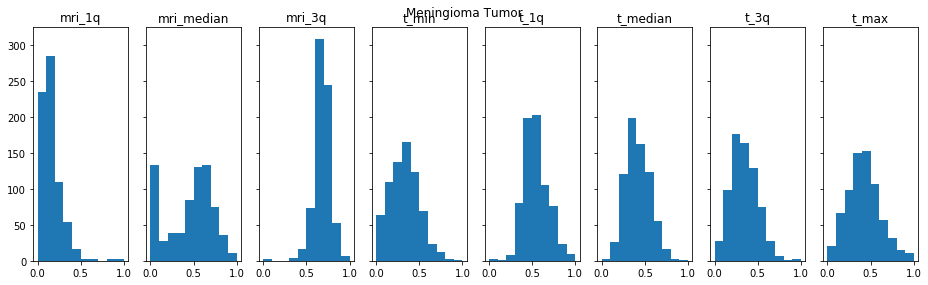

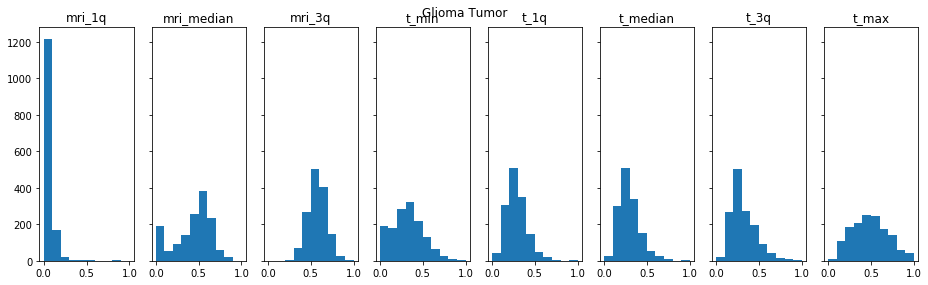

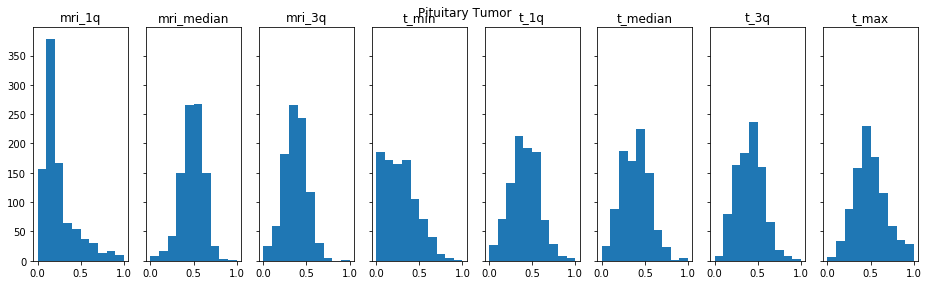

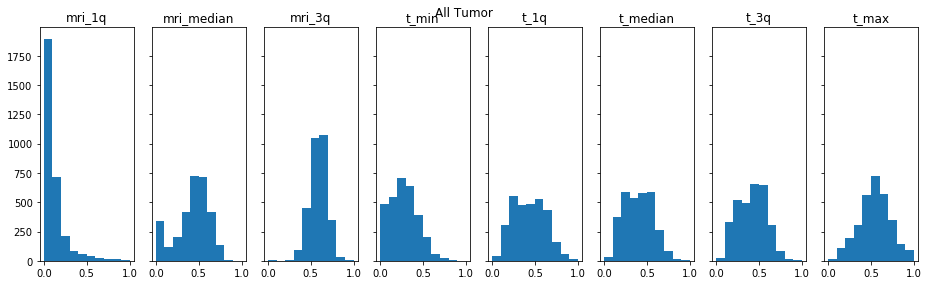

In [31]:
def plotStatistics(df, tumor_name):
  df = df[["mri_1q","mri_median","mri_3q","t_min","t_1q","t_median","t_3q","t_max"]]
  df=(df-df.min())/(df.max()-df.min())
  fig, ax = plt.subplots(1, 8,sharex=True,sharey=True,tight_layout=True)
  fig.set_figheight(4)
  fig.set_figwidth(13)
  
  fig.suptitle(tumor_name+" Tumor")
  #plt.subplot(1,8,1)
  ax[0].hist(df.mri_1q.tolist())
  ax[0].set_title("mri_1q")
  #plt.subplot(1,8,2)
  ax[1].hist(df.mri_median.tolist())
  ax[1].set_title("mri_median")
  #plt.subplot(1,8,3)
  ax[2].hist(df.mri_3q.tolist())
  ax[2].set_title("mri_3q")
  #plt.subplot(1,8,4)
  ax[3].hist(df.t_min.tolist())
  ax[3].set_title("t_min")
  #plt.subplot(1,8,5)
  ax[4].hist(df.t_1q.tolist())
  ax[4].set_title("t_1q")
  #plt.subplot(1,8,6)
  ax[5].hist(df.t_median.tolist())
  ax[5].set_title("t_median")
  #plt.subplot(1,8,7)
  ax[6].hist(df.t_3q.tolist())
  ax[6].set_title("t_3q")
  #plt.subplot(1,8,8)
  ax[7].hist(df.t_max.tolist())
  ax[7].set_title("t_max")
  plt.show()

plotStatistics(df[df.label ==1], tumor_names[1])
plotStatistics(df[df.label ==2], tumor_names[2])
plotStatistics(df[df.label ==3], tumor_names[3])
plotStatistics(df, "All")

## Can we reduce the image size ?
* Why?
  * faster model building
  * lower convolution experiment iterations
  * lower ram usage and hence higher batch size



### Approach 1 : Can we segregate the skull ?
  * removing the unwanted area 
    * percentile approach: identify the percentile and see if any of the tumor percentile is always less that the MRI percentile. 
        i.e. to prove mri_99 > t_99. This failed as indicated below
    * brightness based skull identification:
      * nearest neighbor ???

In [32]:
df[df.mri_99 < df.t_99]

,pid,mri_min,mri_max,mri_1q,mri_median,mri_3q,mri_80,mri_85,mri_90,mri_95,mri_96,mri_97,mri_98,mri_99,t_min,t_max,t_1q,t_median,t_3q,t_80,t_85,t_90,t_95,t_96,t_97,t_98,t_99,tumor_size,file_name,label,square_shape
24,49,0.0,1.0,0.012013,0.031494,0.317532,0.358117,0.423377,0.501623,0.580844,0.602273,0.628247,0.662013,0.711039,0.121429,0.830519,0.393831,0.472078,0.520455,0.535065,0.552273,0.575877,0.626299,0.639532,0.658354,0.680825,0.712653,"(5004,)",120.mat,1,70.738957
34,49,0.0,1.0,0.012369,0.017934,0.159864,0.172542,0.188621,0.286333,0.414966,0.427335,0.442177,0.461039,0.487322,0.107607,0.575758,0.410560,0.428262,0.450835,0.456710,0.463203,0.470625,0.480829,0.483302,0.487013,0.491960,0.498148,"(8000,)",13.mat,1,89.442719
37,49,0.0,1.0,0.011944,0.017585,0.291639,0.311878,0.333112,0.377571,0.548772,0.587923,0.624088,0.666224,0.719973,0.174187,0.783344,0.433477,0.541141,0.611812,0.625415,0.648308,0.668547,0.692435,0.700066,0.708096,0.720305,0.737027,"(4531,)",132.mat,1,67.312703
38,49,0.0,1.0,0.013933,0.019108,0.324841,0.356688,0.391322,0.512341,0.660828,0.689490,0.718551,0.753185,0.800557,0.190287,0.898487,0.603901,0.656847,0.714968,0.728105,0.744427,0.764291,0.795163,0.804140,0.816083,0.827062,0.847532,"(5672,)",133.mat,1,75.312682
39,49,0.0,1.0,0.013475,0.017150,0.273173,0.333606,0.384238,0.519804,0.635770,0.661494,0.691711,0.726011,0.767660,0.195590,0.875459,0.582687,0.622295,0.674153,0.687628,0.702062,0.722744,0.753369,0.759902,0.769812,0.785365,0.810274,"(5992,)",134.mat,1,77.408010
41,49,0.0,1.0,0.015263,0.143773,0.306471,0.328144,0.349817,0.400183,0.526557,0.562882,0.610195,0.667888,0.742979,0.094628,0.969170,0.313797,0.400794,0.494505,0.514347,0.540293,0.578785,0.697848,0.742564,0.770217,0.804890,0.849167,"(5260,)",136.mat,1,72.525857
42,49,0.0,1.0,0.014678,0.084947,0.306371,0.326359,0.347595,0.401624,0.516240,0.546846,0.582136,0.624610,0.680512,0.166146,0.820737,0.313554,0.390693,0.475016,0.492817,0.516240,0.560275,0.625094,0.643498,0.668913,0.692142,0.733076,"(4570,)",137.mat,1,67.601775
43,49,0.0,1.0,0.016996,0.027273,0.373123,0.399209,0.431225,0.507115,0.617787,0.643083,0.669565,0.704348,0.754150,0.186957,0.983004,0.463735,0.536166,0.602372,0.616996,0.632806,0.657708,0.694862,0.704348,0.715708,0.745289,0.808696,"(3122,)",138.mat,1,55.874860
47,49,0.0,1.0,0.018622,0.023588,0.280571,0.311608,0.360025,0.507759,0.617629,0.640596,0.664184,0.693358,0.739292,0.281813,0.810056,0.605214,0.647424,0.679081,0.684792,0.693979,0.703911,0.727064,0.731124,0.734562,0.740534,0.754190,"(2355,)",141.mat,1,48.528342
48,49,0.0,1.0,0.012462,0.016239,0.315332,0.358761,0.402568,0.498489,0.665785,0.698263,0.726208,0.756420,0.794184,0.258686,0.891994,0.606118,0.713746,0.796828,0.809668,0.817806,0.830702,0.856873,0.860906,0.865004,0.869086,0.875378,"(1584,)",142.mat,1,39.799497


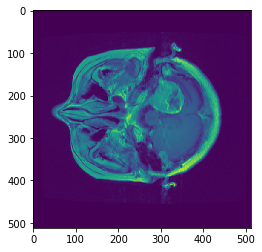

In [33]:
plt.imshow(retrieveImage("120.mat"))
plt.show()

### Approach 2: PCA
* Note that if we do the PCA transformation, we 2D image will be reduced to 1D. Therefore, we can not use it for the Convolution approach.
  * we can note here that just by 2 features (components) and the trained PCA model, we are able to recreate the image with not much difference. [See the last 3 images] This showcases the PCA strength.

* Withhelding the PCA approach as we are going to pursuit the Convolution 


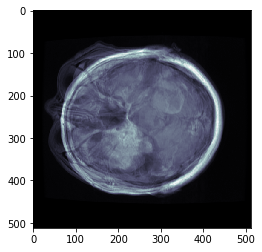

52.76002015371554
(1, 262144)


array([[-3.16526165e-01,  2.40060890e+00, -4.55752075e-01,
        -2.31229479e-01,  9.57613335e-04]])

In [34]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=5,whiten=True)
image=[]
image.append(retrieveImage("120.mat").reshape(-1))
image.append(retrieveImage("1.mat").reshape(-1))
image.append(retrieveImage("2.mat").reshape(-1))
image.append(retrieveImage("3.mat").reshape(-1))
image.append(retrieveImage("4.mat").reshape(-1))
image.append(retrieveImage("5.mat").reshape(-1))
image.append(retrieveImage("6.mat").reshape(-1))
image.append(retrieveImage("7.mat").reshape(-1))

#print(image.shape)

pca.fit(image)
plt.imshow(pca.mean_.reshape((512,512)),
           cmap=plt.cm.bone)
plt.show()

print(pca.noise_variance_)
print(image[0].reshape((1,-1)).shape)
pca.transform(image[0].reshape((1,-1)))

#plt.imshow(pca.transform(image[1].reshape(1,-1)).reshape((512,512)),cmap=plt.cm.bone)


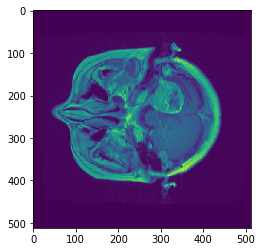

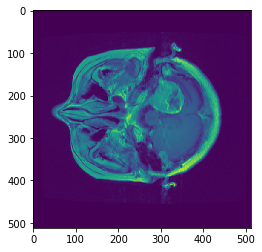

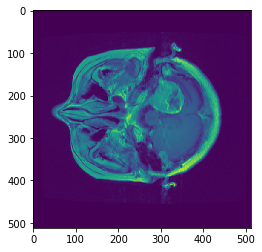

doe it match : [[False False False ...  True  True  True]
 [ True False  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [35]:
components = pca.transform(image[0].reshape(1,-1))
projected = pca.inverse_transform(components)
plt.imshow(projected.reshape((512,512)))
plt.show()
plt.imshow(image[0].reshape((512,512)))
plt.show()
plt.imshow(retrieveImage("120.mat"))
plt.show()
print("doe it match :", projected.reshape((512,512)) == retrieveImage("120.mat"))

In [36]:
plt.imshow(image[0].reshape((256,256)))
plt.show()

ValueError: ignored

## Visual Analysis

### Smallest Tumor Sample

plt.imshow(retrieveImage(list(df[df.tumor_size == df.tumor_size.min()]['file_name'])[0]));
plt.imshow(retrieveTumorImage(list(df[df.tumor_size == df.tumor_size.min()]['file_name'])[0]),alpha=0.5);
plt.show()


### Biggest Tumor in the Dataset

plt.imshow(retrieveImage(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0]));
plt.imshow(retrieveTumorImage(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0]),alpha=0.5);
plt.show()


### Numpy Resize failed

plt.imshow(np.resize(retrieveImage(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0]),(256,256)));
plt.show()

### Bokeh Plot

def bokehPlot(file_name, tumor_label):
  tumor_names = ["","Meningioma","Glioma","Pituitary"]
  im = retrieveImage(file_name)
  s1 = figure(width=512, plot_height=512, title=tumor_names[tumor_label]+" MRI Image")
  s1.image([im],x=[0],y=[0],dw=[512],dh=[512])

  im2 = retrieveTumorImage(file_name)

  s2 = figure(width=500, plot_height=500, title=tumor_names[tumor_label]+" MRI Image with Tumor Highlighted")
  s2.image([im2],x=[0],y=[0],dw=[512],dh=[512])
  s2.image([im],x=[0],y=[0],dw=[512],dh=[512],global_alpha=0.5)

  show(row(s1,s2))

bokehPlot(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0], list(df[df.tumor_size == df.tumor_size.max()]['label'])[0])

#### Meningioma Plots

for fname in list(df[df.label == 1].sample(3)["file_name"]):
  bokehPlot(fname,1)

#### Glioma Plots

for fname in list(df[df.label == 2].sample(3)["file_name"]):
  bokehPlot(fname,2)

#### Pituitary Plots

for fname in list(df[df.label == 3].sample(3)["file_name"]):
  bokehPlot(fname,3)

# Preprocessing


Preprocessing ideas:

1.  Dataset has tumor region indicator which would allow us to get the average brightness of the area.

2. It is said that brightest region is skull and skull is not important for the tumor detection. It is only brain position determines the tumor class. If we remove skull remaining image is brain ?

3. if we start with a window of image which would maximize the presence of tumor and expand to include some brain region around the tumor then i guess it is the best data for training(and predicting). Because tumor position in brain is THE factor that decides the tumor class.

4. what is the optimum batch size for training?

5. what is the overall Image augumented training dataset size ?



## Train & Test split



In [0]:
def getSplit(df):
  df_test=df.sample(frac=.2)
  df = df.drop(df_test.index)
  return df, df_test

df_orig = df.copy()
df,df_test = getSplit(df)

## Batch Creation

In [38]:
df.groupby("label").agg("count").reset_index()

,label,pid,mri_min,mri_max,mri_1q,mri_median,mri_3q,mri_80,mri_85,mri_90,mri_95,mri_96,mri_97,mri_98,mri_99,t_min,t_max,t_1q,t_median,t_3q,t_80,t_85,t_90,t_95,t_96,t_97,t_98,t_99,tumor_size,file_name,square_shape
0,1,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578,578
1,2,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131,1131
2,3,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742


In [45]:
def returnBatchIndices(df,batch_size):
  label_1 = df[df.label == 1].index.tolist()
  label_2 = df[df.label == 2].index.tolist()
  label_3 = df[df.label == 3].index.tolist()

  label_list = []
  #print(len(label_1), len(label_2),len(label_3),list(range(0,max(len(label_1),len(label_2),len(label_3)),batch_size)))
  for i in range(0,max(len(label_1),len(label_2),len(label_3)),batch_size):
    label_list.append(label_1[i:i+batch_size] + label_2[i:i+batch_size] + label_3[i:i+batch_size])
  return label_list

#yieldbatch(df,5)
for batch in returnBatchIndices(df,5):
  print(batch)
  break

print("Total Number of Batches: ", len(returnBatchIndices(df,5)))

[0, 1, 2, 3, 4, 124, 684, 686, 687, 690, 544, 677, 681, 682, 683]
Total Number of Batches:  227


### For Convolution

In [42]:
def returnABatch(df,batch_size):
  #returns a balanced label mri images
  index_list = returnBatchIndices(df,batch_size)
  #print("index list",len(list(index_list)))
  df2 = pd.get_dummies(df['label'], prefix = 'label')
  df = pd.concat([df,df2],axis=1)
  for j in index_list:
    batch_images=[]
    batch_labels=[]
    #print("j",j)
    for i in j:
      #print("i",i)
      label_list=[]
      image = retrieveImage(list(df[df.index == i]['file_name'])[0])
      transformed_image = image.reshape((512,512,1))
      batch_images.append(transformed_image)
      label_list.append(df[df.index == i]['label_1'].tolist()[0])
      label_list.append(df[df.index == i]['label_2'].tolist()[0])
      label_list.append(df[df.index == i]['label_3'].tolist()[0])
      batch_labels.append(label_list)
      #print("Batches :",len(batch_images),len(batch_labels))

    #from keras.utils import to_categorical
    #batch_labels = to_categorical(batch_labels)
    yield np.array(batch_images), np.array(batch_labels)

for i in returnABatch(df.reset_index(),2)  :
  if i[1].shape[0] < 6:
    print(len(i),len(i[1]))
    print(i[0].shape)
    print(i[1])
    break

Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
2 4
(4, 512, 512, 1)
[[0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]]


### For Logistic Regression

In [43]:
def returnABatch1d(df,batch_size):
  #returns a balanced label mri images
  index_list = returnBatchIndices(df,batch_size)
  #print("index list",len(list(index_list)))
  df2 = pd.get_dummies(df['label'], prefix = 'label')
  df = pd.concat([df,df2],axis=1)
  for j in index_list:
    batch_images=[]
    batch_labels=[]
    #print("j",j)
    for i in j:
      #print("i",i)
      label_list=[]
      image = retrieveImage(list(df[df.index == i]['file_name'])[0])
      transformed_image = image.reshape(512*512)
      batch_images.append(transformed_image)
      label_list.append(df[df.index == i]['label_1'].tolist()[0])
      label_list.append(df[df.index == i]['label_2'].tolist()[0])
      label_list.append(df[df.index == i]['label_3'].tolist()[0])
      batch_labels.append(label_list)
      #print("Batches :",len(batch_images),len(batch_labels))

    #from keras.utils import to_categorical
    #batch_labels = to_categorical(batch_labels)
    yield np.array(batch_images), np.array(batch_labels)

for i in returnABatch1d(df.reset_index(),2)  :
  if i[1].shape[0] < 6:
    print(len(i),len(i[1]))
    print(i[0].shape)
    print(i[1])
    break

Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the image :  (256, 256)
2 4
(4, 262144)
[[0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]]


#Model Building


## CNN Approach using Tensorflow keras

In [0]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(512,512,3))
            ,tf.keras.layers.MaxPooling2D(2,2)
            ,tf.keras.layers.Conv2D(64, (3,3), activation="relu")
            ,tf.keras.layers.MaxPooling2D(2,2)
            ,tf.keras.layers.Conv2D(64, (3,3), activation="relu")
            ,tf.keras.layers.MaxPooling2D(2,2)
            ,tf.keras.layers.Conv2D(64, (3,3), activation="relu")
            ,tf.keras.layers.MaxPooling2D(2,2)
            ,tf.keras.layers.Conv2D(64, (3,3), activation="relu")
            ,tf.keras.layers.MaxPooling2D(2,2)
            ,tf.keras.layers.Flatten()
            ,tf.keras.layers.Dropout(0.5)
            ,tf.keras.layers.Dense(512, activation="relu")
            ,tf.keras.layers.Dense(3,activation="softmax")            
])

model.compile(loss="categorical_crossentropy"
              ,optimizer= "adam"
              ,metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 510, 510, 64)      1792      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 255, 255, 64)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 253, 253, 64)      36928     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 60, 60, 64)       

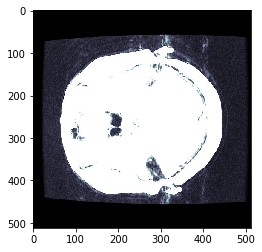

In [44]:
img = plt.imread("/content/data/1/1.jpg")
plt.imshow(img,cmap="bone")

In [0]:
history=model.fit_generator(train_generator
                  #,steps_per_epoch=286
                  #, epochs=5
                  )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
33/79 [===========>..................] - ETA: 14:38 - loss: 11.6066 - accuracy: 0.2765

KeyboardInterrupt: ignored

## Logistic Regression using Tensorflow Keras

In [0]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(3,input_dim=512*512, activation="softmax")            
])

model.compile(loss="categorical_crossentropy"
              ,optimizer= "adam"
              ,metrics=["accuracy"])
model.summary()

batch_size = 64
steps_per_epoch = round(df.groupby("label").agg("count").reset_index()['pid'].max()/batch_size)

print("Total Training Dataset : ", df.shape[0])
print("Batch Size : ", batch_size)
print("Steps per epoch : ", steps_per_epoch)
print("Test Datasize shape : ", df_test.shape[0])

history=model.fit_generator(returnABatch1d(df,batch_size)
                  ,steps_per_epoch=steps_per_epoch
                  , epochs=5
                  )

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Testing
* is the model bias for 256 size images ?
* is there any imbalance in 256 size images ?
* converting 512x512 to 256x256 size would definitely speed up the process but would it impact the accuracy ?
* is the model has better accuracy for any type of tumor class? (as we have imbalanced set ?

# Observations / Lesson Learnt:

* Iteration 1:
  * CNN of 512x512 took half an hour even on TPU
  * more and more convolution layer decreases the neurons required for training( duh!!!) and hence the batch size can be increased.
  * testing result was 49%. Not Acceptable.

* Iteration 2:
  * tried PCA but realized transformation is not suited for convolution
  * tried to use imagegenerator by converting the numpy to image (jpg) file. But found that numpy to image was not successfull.


  